# Imports

In [1]:
from skimage.segmentation import watershed, felzenszwalb
from skimage.filters import sobel
import pandas as pd
from pathlib import Path
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.filters import rank
from scipy import ndimage as ndi
from skimage.morphology import disk
import sklearn.metrics

c:\Users\alexa\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Setup

First, you need to access the data from this colab.

A way to do this is to add the following shared drive to your google drive:
https://drive.google.com/drive/folders/1AfBKbAmrMTLLH33441c5RSlwLp3ePhVT?usp=share_link


In order to do this, just rick-click on the drive and click "Add a shortcut to my Drive"

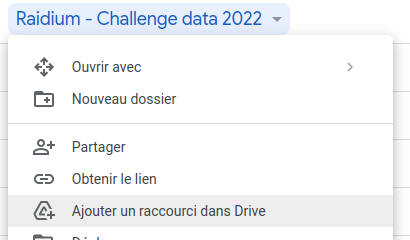

# Handling the data

In [2]:
# Load the train labels
# Note the transpose!
data_dir = Path("C:/Users/alexa/Desktop/datachallenge")
labels_train = pd.read_csv(data_dir  / "Y_train.csv", index_col=0).T

In [13]:
np.unique(labels_train[1:2])

array([  0,  19,  24,  28,  31,  39,  47,  52,  55,  56,  66,  72,  75,
        91, 100, 101], dtype=int64)

In [2]:
# Here is a function to load the data
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

In [5]:
# Load the train and test sets
# If you've put the shortcut directly in your drive, this should work out of the box
# Else, edit the path
data_dir = Path("C:/Users/alexa/Desktop/datachallenge")
data_train = load_dataset(data_dir / "X_train")
data_test = load_dataset(data_dir / "X_test")

In [10]:
# The train data is a numpy array of 1000 images of 512*512
print(f"X_train shape: {data_train.shape}")
# The train label is a dataframe of 1000 rows with 262144 (=512x512) columns
print(f"Y_train shape: {labels_train.shape}")

X_train shape: (2000, 512, 512)
Y_train shape: (2000, 262144)


In [45]:
# Let's display some data
# Here is a function to display side by side a slide and a segmented mask
def plot_slice_seg(slice_image, seg):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(slice_image, cmap="gray")
    axes[1].imshow(slice_image, cmap="gray")
    seg_masked = np.ma.masked_where(seg.reshape((512,512)) == 0, (seg.reshape((512,512))))
    axes[1].imshow(seg_masked, cmap="tab20")
    plt.axis("off")
    plt.savefig("./")
    plt.close(fig)
    return fig
# Let's try it on a slide and ites segmentation mask
# Note: we have to reshape the rows of the dataframe into a 512*512 matrix
test = plot_slice_seg(data_train[399], labels_train.iloc[399].values.reshape((512,512)))

In [50]:
pd.read_csv(data_dir / "Y_train.csv", index_col=0).T.values

KeyboardInterrupt: 

# Let's compute a baseline

In [13]:
# Let's take a very basic watershed baseline
def compute_baseline_one_sample(data_slice):
    edges = sobel(data_slice)
    denoised = rank.median(data_slice, disk(2))
    markers = rank.gradient(denoised, disk(5)) < 20
    markers = ndi.label(markers)[0]
    # print(markers)
    label_predicted = watershed(edges, markers=markers, compactness=0.0001)
    return label_predicted

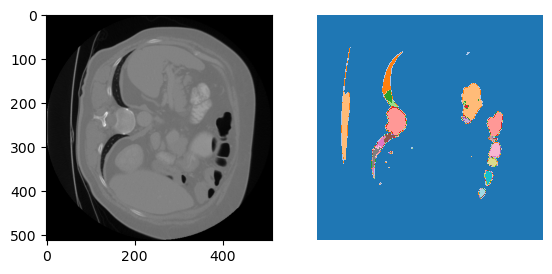

In [14]:
# Let's display the results
# Not too bad!
plot_slice_seg(data_train[2], compute_baseline_one_sample(data_train[2]))

## Let's measure its performances

In [15]:
# Compute the baseline on a whole dataset
def compute_baseline(dataset: np.array):
    labels_predicted_list = []
    for data_index in tqdm(range(len(dataset))):
        data_slice = dataset[data_index]
        label_predicted = compute_baseline_one_sample(data_slice)
        labels_predicted_list.append(label_predicted)
    return pd.DataFrame(np.stack(labels_predicted_list, axis=0).reshape((len(labels_predicted_list), -1)))

In [16]:
# Let's create a validation set first: the 200 first images of the train set
data_val = data_train[:200]
labels_val = labels_train.iloc[:200]

In [17]:
# Compute baseline on a few train data
labels_val_predicted_baseline = compute_baseline(data_val)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:56<00:00,  3.52it/s]


In [20]:
def rand_index_dataset(y_true_df: pd.DataFrame, y_pred_df: pd.DataFrame) -> float:
    """Compute the individual rand index for each sample in the dataset and then average it"""
    individual_rand_index = []
    for row_index in range(y_true_df.values.shape[0]):
        labels = y_true_df.values[row_index]
        preds = y_pred_df.values[row_index]
        individual_rand_index.append(sklearn.metrics.adjusted_rand_score(labels, preds))
    print(individual_rand_index)
    return np.mean(individual_rand_index)

In [21]:
# Compute the metric on the validation set
rand_index_dataset(labels_val, labels_val_predicted_baseline)
# We get => 0.14 (0.1369409193608601); Not so bad, but room for improvements!
# Let's see if you can do better!

[-0.03771856645198838, -0.009375126224358515, 0.046853675163343954, 0.15810738655707018, 0.21383542754022072, 0.42438126171571877, 0.12253449244854135, 0.3832312376049313, 0.04330220987808962, 0.05636428714160994, 0.12598832744094698, 0.16410434452142122, 0.22559788566943492, 0.49232607215187524, 0.13519558719897967, 0.34808912684509674, 0.41603408812240145, 0.2710079298472267, 0.07929324597255312, 0.12773116113551627, 0.004448222943960355, 0.015067998539833673, -0.008726063462585644, 0.48361204643245964, 0.0835541789912744, 0.06119637325556469, -0.12791694522016528, -0.04642128432202073, 0.2361679143580434, -0.03912540121272846, 0.07374111556146704, -0.09177556934832734, -0.06961539407656286, 0.0279997835699793, -0.000739665393108883, 0.08834639052313492, 0.2102825946860887, -0.028005377464867844, -0.009798223363094065, 0.03690826514888975, 0.05376661224666287, 0.5997282907117627, 0.5621402681305449, 0.4251994264285501, 0.12000879144316073, 0.06899202626417363, 0.39328184633220487, 0.

0.1400907465368057

# Traitional technics
- watershed already tried
- k-means
- gaussian mixture

## K-Means


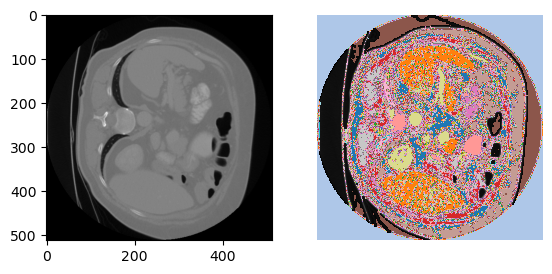

In [17]:
from sklearn.cluster import KMeans


def compute_KMeans_one_sample(data_slice):
    w,h = data_slice.shape
    x,y = np.meshgrid(np.arange(w),np.arange(h))


    denoised = np.stack((rank.median(data_slice, disk(2)).ravel(),(x/w).ravel(),(y/h).ravel()),axis=1)

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=20, random_state=42,n_init=10,)
    
    kmeans.fit(denoised)

    # Get the cluster centers and labels for each pixel
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    return labels

# len(compute_KMeans_one_sample(data_train[2]))
plot_slice_seg(data_train[2], compute_KMeans_one_sample(data_train[2]))

In [70]:
# Compute the baseline on a whole dataset
def compute_KMeans(dataset: np.array):
    labels_predicted_list = []
    for data_index in tqdm(range(len(dataset))):
        data_slice = dataset[data_index]
        label_predicted = compute_KMeans_one_sample(data_slice)
        labels_predicted_list.append(label_predicted)
    return pd.DataFrame(np.stack(labels_predicted_list, axis=0).reshape((len(labels_predicted_list), -1)))

In [ ]:
# Compute baseline on a few train data
labels_val_predicted_KMeans = compute_KMeans(data_val)
# Compute the metric on the validation set
rand_index_dataset(labels_val, labels_val_predicted_baseline)

## Gaussian Mixture


[5 5 5 ... 5 5 5]


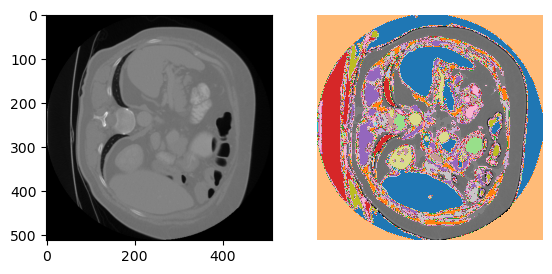

In [28]:
from sklearn.mixture import GaussianMixture



def compute_GMM_one_sample(data_slice):
    w,h = data_slice.shape
    x,y = np.meshgrid(np.arange(w),np.arange(h))

    denoised = rank.median(data_slice,disk(5)).reshape(-1,1)
    
    gmm = GaussianMixture(n_components=25, random_state=42)
    
    gmm.fit(denoised)

    labels = gmm.predict(denoised)
    return labels

print(compute_GMM_one_sample(data_train[2]))
plot_slice_seg(data_train[2], compute_GMM_one_sample(data_train[2]))

The issue with kmeans and GMM is that we don't know how many clusters we have for each image. We can look the BIC or AIC scores but this is really time consuming as we have to do it again for each image. 

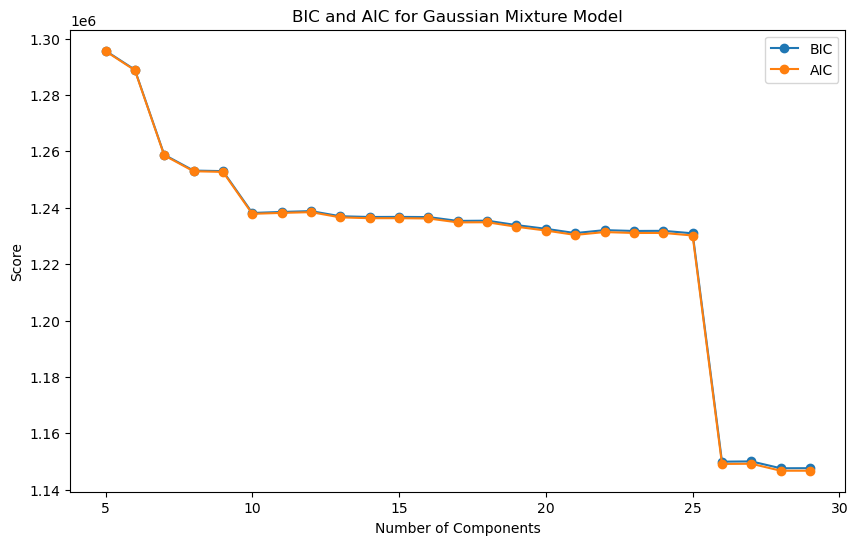

In [31]:

# Define range for the number of components
n_components = range(5, 30)

# Lists to store BIC and AIC values
bic_values = []
aic_values = []


pixels = rank.median(data_train[2],disk(5)).reshape(-1,1)

# Fit GMMs with varying components and calculate BIC/AIC
for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(pixels)
    bic_values.append(gmm.bic(pixels))
    aic_values.append(gmm.aic(pixels))

# Plot BIC and AIC scores
plt.figure(figsize=(10, 6))
plt.plot(n_components, bic_values, label='BIC', marker='o')
plt.plot(n_components, aic_values, label='AIC', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('BIC and AIC for Gaussian Mixture Model')
plt.legend()
plt.show()

# Machine learning Methods

## Random Forest

In [40]:

from sklearn.ensemble import RandomForestClassifier

def train_RF(list_data_slice,labels):
    w,h = list_data_slice[0].shape
    x,y = np.meshgrid(np.arange(w),np.arange(h))

    # Extract features (intensity + coordinates)
    features = np.array([np.stack((data_slice.ravel(), x.ravel(), y.ravel()), axis=1) for data_slice in list_data_slice])

    features = np.vstack(features)
    labels = np.hstack(np.array(labels))
    print(features)
    print(labels)

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(features,labels)

    return rf_model

    
rf = train_RF(data_train[:200],labels_train[:200])


plot_slice_seg(data_train[2],rf.predict([data_train]))

[[ 19   0   0]
 [ 18   1   0]
 [ 16   2   0]
 ...
 [ 15 509 511]
 [ 15 510 511]
 [ 15 511 511]]
[0 0 0 ... 0 0 0]


MemoryError: could not allocate 14227079168 bytes

# Deep learning methods

In [7]:
import model 
from importlib import reload  # Python 3.4+
import torch
torch.cuda.empty_cache()
reload(model)
# from PIL import Image
# im = Image.open("C:/Users/alexa/Desktop/datachallenge/X_train/0.png").convert('L')
# print(np.array(im))
# print(data_train[0])

model.test()

torch.Size([3, 1, 512, 512])
torch.Size([3, 262144])
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1988 MiB |   2686 MiB |   6657 MiB |   4669 MiB |
|       from large pool |   1982 MiB |   2676 MiB |   6637 MiB |   4654 MiB |
|       from small pool |      5 MiB |     10 MiB |     20 MiB |     14 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   1988 MiB |   2686 MiB |   6657 MiB |   4669 MiB |
|       fro

In [7]:
from importlib import reload  # Python 3.4+
import train
reload(train)
# torch.cuda.empty_cache()
train.main()

200
200
0
200


100%|██████████| 50/50 [00:16<00:00,  2.99it/s, loss=2.73e+7]


=> save checkpoint


RuntimeError: Given groups=1, weight of size [16, 1, 3, 3], expected input[1, 4, 512, 512] to have 1 channels, but got 4 channels instead

FileNotFoundError: [Errno 2] No such file or directory: './pred/0/test.png'

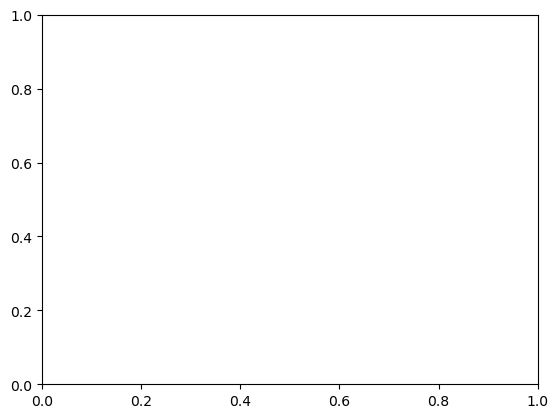

In [11]:
import matplotlib.pyplot as plt

fig = plt.subplot()

plt.savefig("./pred/0/test.png")

In [43]:
import utils
import torch
import model

from importlib import reload 
reload(utils)


# Hyperaprameters etc
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 2
NUM_EPOCHS = 10
NUM_WORKERS = 2
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
PIN_MEMORY = True
LOAD_MODEL = True
TRAIN_IMG_DIR = "C:/Users/alexa/Desktop/datachallenge/X_train"
TRAIN_MASK_DIR = "C:/Users/alexa/Desktop/datachallenge/Y_train.csv"
# TRAIN_MASK_DIR = ""
TEST_IMG_DIR = "C:/Users/alexa/Desktop/datachallenge/X_test"
TEST_MASK_DIR = "C:/Users/alexa/Desktop/datachallenge/pred"


modelunet = model.UNET(in_channels = 1, out_channels = 106).to(DEVICE)


train_loader, val_loader = utils.get_loaders(
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    train_dir=TRAIN_IMG_DIR,
    train_maskdir=TRAIN_MASK_DIR,
    train_transform=None,
    val_dir=TEST_IMG_DIR,
    val_maskdir=TEST_MASK_DIR,
    val_transform=None,
    index=2000
)

# utils.load_checkpoint(torch.load("./checkpoint-97.pth.tar"),modelunet)

# utils.save_prediction_as_imgs(
#     train_loader, modelunet, folder=f"./pred/final/",batch_size=BATCH_SIZE
# )
# output = utils.save_predictions_to_csv(val_loader,modelunet,"./Y_test.csv")

In [44]:
modelunet = model.UNET(in_channels = 1, out_channels = 106).to(DEVICE)

# utils.load_checkpoint(torch.load("./checkpoints/checkpoint-210.pth.tar"),modelunet)


In [13]:
reload(utils)
utils.save_prediction_as_imgs(
    train_loader, modelunet, folder=f"./Y_train/",batch_size=BATCH_SIZE,some=False
)

# utils.save_prediction_as_imgs(
#     val_loader, modelunet, folder=f"./Y_test/",batch_size=BATCH_SIZE
# )

--batch 0--
 -> image 0
 -> image 1
--batch 1--
 -> image 2
 -> image 3
--batch 2--
 -> image 4
 -> image 5
--batch 3--
 -> image 6
 -> image 7
--batch 4--
 -> image 8
 -> image 9
--batch 5--
 -> image 10
 -> image 11
--batch 6--
 -> image 12
 -> image 13
--batch 7--
 -> image 14
 -> image 15
--batch 8--
 -> image 16
 -> image 17
--batch 9--
 -> image 18
 -> image 19
--batch 10--
 -> image 20
 -> image 21
--batch 11--
 -> image 22
 -> image 23
--batch 12--
 -> image 24
 -> image 25
--batch 13--
 -> image 26
 -> image 27
--batch 14--
 -> image 28
 -> image 29
--batch 15--
 -> image 30
 -> image 31
--batch 16--
 -> image 32
 -> image 33
--batch 17--
 -> image 34
 -> image 35
--batch 18--
 -> image 36
 -> image 37
--batch 19--
 -> image 38
 -> image 39
--batch 20--
 -> image 40
 -> image 41
--batch 21--
 -> image 42
 -> image 43
--batch 22--
 -> image 44
 -> image 45
--batch 23--
 -> image 46
 -> image 47
--batch 24--
 -> image 48
 -> image 49
--batch 25--
 -> image 50
 -> image 51
--batc

In [17]:
output = utils.save_predictions_to_csv(val_loader,modelunet,"./Y_test.csv")

--batch 0--
--batch 1--
--batch 2--
--batch 3--
--batch 4--
--batch 5--
--batch 6--
--batch 7--
--batch 8--
--batch 9--
--batch 10--
--batch 11--
--batch 12--
--batch 13--
--batch 14--
--batch 15--
--batch 16--
--batch 17--
--batch 18--
--batch 19--
--batch 20--
--batch 21--
--batch 22--
--batch 23--
--batch 24--
--batch 25--
--batch 26--
--batch 27--
--batch 28--
--batch 29--
--batch 30--
--batch 31--
--batch 32--
--batch 33--
--batch 34--
--batch 35--
--batch 36--
--batch 37--
--batch 38--
--batch 39--
--batch 40--
--batch 41--
--batch 42--
--batch 43--
--batch 44--
--batch 45--
--batch 46--
--batch 47--
--batch 48--
--batch 49--
--batch 50--
--batch 51--
--batch 52--
--batch 53--
--batch 54--
--batch 55--
--batch 56--
--batch 57--
--batch 58--
--batch 59--
--batch 60--
--batch 61--
--batch 62--
--batch 63--
--batch 64--
--batch 65--
--batch 66--
--batch 67--
--batch 68--
--batch 69--
--batch 70--
--batch 71--
--batch 72--
--batch 73--
--batch 74--
--batch 75--
--batch 76--
--batch 7

In [8]:
import numpy as np
np.unique(output)

array([ 0, 24, 41, 64])

In [6]:
reload(utils)
utils.check_accuracy(train_loader,modelunet,106)

---check accuracy---


100%|██████████| 200/200 [00:20<00:00,  9.53it/s]


torch.Size([400, 262144])
torch.Size([400, 262144])
20.982571363449097
22.30974578857422
66.87136054039001
149.2920434474945
159.3090672492981


,pixel accuracy,dice coefficient,mean IoU,adjusted rand index :
0,0.737844,0.010414,0.008972,0.522847


In [6]:
utils.check_accuracy(train_loader,modelunet,106)

---check accuracy---


100%|██████████| 200/200 [00:21<00:00,  9.22it/s]


,pixel accuracy,adjusted rand index
0,0.79497,0.856878


In [14]:
utils.check_accuracy(train_loader,modelunet,106)

---check accuracy---


100%|██████████| 200/200 [00:36<00:00,  5.47it/s]


,pixel accuracy,adjusted rand index
0,0.825446,0.887349


In [16]:
utils.check_accuracy(train_loader,modelunet,106)

---check accuracy---


100%|██████████| 200/200 [00:26<00:00,  7.46it/s]


,pixel accuracy,adjusted rand index
0,0.913816,0.91949


In [19]:
utils.check_accuracy(train_loader,modelunet,106)

---check accuracy---


100%|██████████| 200/200 [00:33<00:00,  5.90it/s]


,pixel accuracy,adjusted rand index
0,0.938481,0.924842


In [23]:
reload(utils)
output = utils.save_predictions_to_csv(train_loader,modelunet,"./")

--batch 0--
--batch 1--
--batch 2--
--batch 3--
--batch 4--
--batch 5--
--batch 6--
--batch 7--
--batch 8--
--batch 9--
--batch 10--
--batch 11--
--batch 12--
--batch 13--
--batch 14--
--batch 15--
--batch 16--
--batch 17--
--batch 18--
--batch 19--
--batch 20--
--batch 21--
--batch 22--
--batch 23--
--batch 24--
--batch 25--
--batch 26--
--batch 27--
--batch 28--
--batch 29--
--batch 30--
--batch 31--
--batch 32--
--batch 33--
--batch 34--
--batch 35--
--batch 36--
--batch 37--
--batch 38--
--batch 39--
--batch 40--
--batch 41--
--batch 42--
--batch 43--
--batch 44--
--batch 45--
--batch 46--
--batch 47--
--batch 48--
--batch 49--
--batch 50--
--batch 51--
--batch 52--
--batch 53--
--batch 54--
--batch 55--
--batch 56--
--batch 57--
--batch 58--
--batch 59--
--batch 60--
--batch 61--
--batch 62--
--batch 63--
--batch 64--
--batch 65--
--batch 66--
--batch 67--
--batch 68--
--batch 69--
--batch 70--
--batch 71--
--batch 72--
--batch 73--
--batch 74--
--batch 75--
--batch 76--
--batch 7

In [40]:
import numpy as np
newlabels = np.zeros(train_loader.dataset.get_masks().shape)
newlabels[:400] = np.copy(train_loader.dataset.get_masks()[:400,])
newlabels[400:] = np.copy(output.T[400:])

In [42]:
import pandas as pd
pd.DataFrame(newlabels.T).to_csv("./newY_train.csv")

In [47]:
max_classes = train_loader.dataset.get_masks().max()+1

import torch.nn as nn
print(f"Max number of class : {max_classes}")
loss_fn = nn.CrossEntropyLoss().to(DEVICE)

modelunet.eval()
train_loss = 0.0

for images, masks in train_loader:
    with torch.no_grad():
        images = images.unsqueeze(1).float().to(DEVICE)
        masks = masks.long().to(DEVICE) 
        assert masks.min() >= 0 and masks.max() < max_classes, "Classe dans les masques hors des limites !"+str(masks.max())




        outputs = modelunet(images)

        loss = (outputs, masks)
        train_loss += loss.item()

print(f"masks dim : {masks.shape}")
print(f"images dim : {images.shape}")
print(f"outputs dim : {outputs.shape}")

avg_loss = train_loss / len(train_loader)
print(f"Initial Loss: {avg_loss:.4f}")

modelunet.train()



Max number of class : 106


OSError: [Errno 22] Invalid argument